In [1]:
from collections import defaultdict, Counter

import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import balanced_accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rmritik/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
main_df = pd.read_pickle('main_df_sampled.pickle')
main_df

,id,subreddit,title,selftext,genre
0,4ra2z6,Throwers,new to this (vibrations),"""i recently got back into yoyos last time i ha...",hobby
1,6dkhwl,weddingplanning,vendor and photographer issues and frustrations,"""your stories and advice are most certainly we...",sex/relationships
2,5jzfbj,redditdev,[praw 360] test if comment is top level ? or ...,"""i mod a sub that is looking into adding a rul...",meta
3,6680x8,csshelp,in /r/modern_hp_theme (a test subreddit) how c...,"""/r/modern_hp_theme space:nowrap;color:#666...",programming
4,4tadox,StrangerThings,mr wheeler stole every scene he was in,"""""""what did i do ? what did iiiiiiiii doooooo...",tv_show
...,...,...,...,...,...
116995,6cum56,LearnJapanese,i'm having trouble reading the number 七十一万四千 w...,what throws me off is the 七十一 at the beginning...,education
116996,6dud8e,HotPeppers,my reaper seeds won't sprout,i'm using the damp towel in plastic bag method...,food/drink
116997,4nyacs,Warmachine,what happened to skorne ?,"""so i have no idea what happened to other fact...",board_game
116998,66y8wp,TalesFromThePizzaGuy,"""""""ma'am i know you're lying right now enjoy y...","""last week we were stupid slow all day and thi...",writing/stories


In [4]:
text_df = main_df['title'].map(str) + " " + main_df['selftext']

In [5]:
# Calculate the number of words in each string
word_counts = [len(sentence.split()) for sentence in text_df]

# Calculate the median number of words
median_word_count = np.median(word_counts)

median_word_count

69.0

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Conv1D, MaxPooling1D, SpatialDropout1D, LSTM, Dense
from tensorflow.keras.optimizers import Adam

EMBEDDING_DIM = 768  # Embedding dimension
MAX_SEQUENCE_LENGTH = int(median_word_count)  # Maximum sequence length
NUM_FILTERS = 64
KERNEL_SIZE = 3

model = Sequential()
model.add(Conv1D(NUM_FILTERS, KERNEL_SIZE, activation='relu', input_shape=(MAX_SEQUENCE_LENGTH, EMBEDDING_DIM)))
model.add(MaxPooling1D(pool_size=2))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(EMBEDDING_DIM, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(39, activation='softmax'))

2024-05-04 16:14:54.271328: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-04 16:15:07.791035: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [50]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [51]:
import torch
from transformers import BertModel, BertTokenizer
import os
import gc
import pickle

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Using device:', device)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')
bert_model.to(device)


def generate_bert_embeddings(text, max_length=int(median_word_count)):
    inputs = tokenizer(text, padding='max_length', truncation=True, max_length=max_length, return_tensors='pt')
    inputs = {key: tensor.to(device) for key, tensor in inputs.items()}  # Move tensors to the same device as the model

    with torch.no_grad():
        outputs = bert_model(**inputs)

    embeddings = outputs.last_hidden_state.squeeze(0)  # remove batch dimension
    return embeddings.cpu().numpy()

def train_lstm_cnn(main_df_sampled, index):

  if os.path.exists(f"/content/drive/MyDrive/training_data/X_{index}") and os.path.exists(f"/content/drive/MyDrive/training_data/Y_{index}"):
    with open(f"/content/drive/MyDrive/training_data/X_{index}", 'rb') as f:
      X_bert = pickle.load(f)

    with open(f"/content/drive/MyDrive/training_data/Y_{index}", 'rb') as f:
      Y = pickle.load(f)
  else:
    text_df = main_df_sampled['title'].map(str) + " " + main_df_sampled['selftext']

    text_df_fixed = []
    for sentence in text_df:
        words = sentence.split()
        if len(words) > median_word_count:
            words = words[:int(median_word_count)]
        modified_sentence = ' '.join(words).strip()
        text_df_fixed.append(modified_sentence)

    X_bert = []
    for i in tqdm(range(len(text_df_fixed))):
      X_bert.append(generate_bert_embeddings(text_df_fixed[i]))

    X_bert = np.array(X_bert)

    Y = pd.get_dummies(main_df_sampled['genre'].values)

    with open(f"/content/drive/MyDrive/training_data/X_{index}", 'wb') as f:

      pickle.dump(X_bert, f)

    with open(f"/content/drive/MyDrive/training_data/Y_{index}", 'wb') as f:

      pickle.dump(Y, f)

  history = model.fit(X_bert, Y, batch_size=64, epochs=1)

  del X_bert, Y

  gc.collect()



Using device: cuda


In [ ]:
batch_size = 200
num_batches = 15

for epoch in range(10):
  main_df_copy = main_df.copy()
  print("Epoch: ", epoch)
  for i in range(int(0.8*num_batches)):
      sampled_data = []
      for genre in main_df['genre'].unique():
          genre_data = main_df_copy[main_df_copy['genre'] == genre].sample(n=batch_size, random_state=42)
          sampled_data.append(genre_data)
          main_df_copy.drop(genre_data.index, inplace=True)

      batch_data = pd.concat(sampled_data)

      batch_data = batch_data.sample(frac=1, random_state=42).reset_index(drop=True)

      print("Processing Batch:", i+1)

      train_lstm_cnn(batch_data, i)

  model.save(f"/content/drive/MyDrive/lstm-cnn/model_epoch_{epoch}.h5")

Epoch:  0
Processing Batch: 1
122/122 [==============================] - 23s 144ms/step - loss: 3.2047 - accuracy: 0.1132
Processing Batch: 2
122/122 [==============================] - 20s 163ms/step - loss: 2.7470 - accuracy: 0.2212
Processing Batch: 3
122/122 [==============================] - 17s 137ms/step - loss: 2.5599 - accuracy: 0.2672
Processing Batch: 4
122/122 [==============================] - 18s 145ms/step - loss: 2.4157 - accuracy: 0.3095
Processing Batch: 5
122/122 [==============================] - 20s 164ms/step - loss: 2.3179 - accuracy: 0.3549
Processing Batch: 6
122/122 [==============================] - 19s 152ms/step - loss: 2.1929 - accuracy: 0.3804
Processing Batch: 7
122/122 [==============================] - 18s 144ms/step - loss: 2.1701 - accuracy: 0.3951
Processing Batch: 8
122/122 [==============================] - 18s 143ms/step - loss: 2.0996 - accuracy: 0.4129
Processing Batch: 9
122/122 [==============================] - 19s 159ms/step - loss: 2.0700 -

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch:  1
Processing Batch: 1
122/122 [==============================] - 17s 138ms/step - loss: 1.9557 - accuracy: 0.4487
Processing Batch: 2
122/122 [==============================] - 20s 161ms/step - loss: 1.9552 - accuracy: 0.4432
Processing Batch: 3
122/122 [==============================] - 17s 137ms/step - loss: 1.9573 - accuracy: 0.4500
Processing Batch: 4
122/122 [==============================] - 17s 136ms/step - loss: 1.8723 - accuracy: 0.4710
Processing Batch: 5
122/122 [==============================] - 20s 160ms/step - loss: 1.8737 - accuracy: 0.4728
Processing Batch: 6
122/122 [==============================] - 18s 149ms/step - loss: 1.8103 - accuracy: 0.4850
Processing Batch: 7
122/122 [==============================] - 17s 143ms/step - loss: 1.8369 - accuracy: 0.4779
Processing Batch: 8
122/122 [==============================] - 22s 177ms/step - loss: 1.7816 - accuracy: 0.4964
Processing Batch: 9
122/122 [==============================] - 17s 140ms/step - loss: 1.7824 -

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch:  2
Processing Batch: 1
122/122 [==============================] - 18s 147ms/step - loss: 1.7273 - accuracy: 0.5136
Processing Batch: 2
122/122 [==============================] - 19s 151ms/step - loss: 1.7495 - accuracy: 0.4977
Processing Batch: 3
122/122 [==============================] - 19s 152ms/step - loss: 1.7473 - accuracy: 0.5062
Processing Batch: 4
122/122 [==============================] - 18s 148ms/step - loss: 1.6980 - accuracy: 0.5188
Processing Batch: 5
122/122 [==============================] - 20s 160ms/step - loss: 1.6881 - accuracy: 0.5181
Processing Batch: 6
122/122 [==============================] - 19s 153ms/step - loss: 1.6477 - accuracy: 0.5288
Processing Batch: 7
122/122 [==============================] - 20s 161ms/step - loss: 1.6729 - accuracy: 0.5262
Processing Batch: 8
122/122 [==============================] - 17s 140ms/step - loss: 1.6314 - accuracy: 0.5363
Processing Batch: 9
122/122 [==============================] - 19s 160ms/step - loss: 1.6412 -

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch:  3
Processing Batch: 1
122/122 [==============================] - 18s 151ms/step - loss: 1.6137 - accuracy: 0.5403
Processing Batch: 2
122/122 [==============================] - 20s 167ms/step - loss: 1.6423 - accuracy: 0.5313
Processing Batch: 3
122/122 [==============================] - 17s 140ms/step - loss: 1.6428 - accuracy: 0.5301
Processing Batch: 4
122/122 [==============================] - 17s 139ms/step - loss: 1.5852 - accuracy: 0.5469
Processing Batch: 5
122/122 [==============================] - 21s 170ms/step - loss: 1.5807 - accuracy: 0.5542
Processing Batch: 6
122/122 [==============================] - 17s 140ms/step - loss: 1.5557 - accuracy: 0.5492
Processing Batch: 7
122/122 [==============================] - 17s 140ms/step - loss: 1.5806 - accuracy: 0.5462
Processing Batch: 8
122/122 [==============================] - 22s 179ms/step - loss: 1.5270 - accuracy: 0.5691
Processing Batch: 9
122/122 [==============================] - 17s 140ms/step - loss: 1.5462 -

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch:  4
Processing Batch: 1
122/122 [==============================] - 17s 143ms/step - loss: 1.5306 - accuracy: 0.5626
Processing Batch: 2
122/122 [==============================] - 20s 165ms/step - loss: 1.5449 - accuracy: 0.5518
Processing Batch: 3
122/122 [==============================] - 17s 140ms/step - loss: 1.5652 - accuracy: 0.5541
Processing Batch: 4
122/122 [==============================] - 17s 143ms/step - loss: 1.5124 - accuracy: 0.5659
Processing Batch: 5
122/122 [==============================] - 17s 142ms/step - loss: 1.5029 - accuracy: 0.5669
Processing Batch: 6
122/122 [==============================] - 20s 163ms/step - loss: 1.4624 - accuracy: 0.5799
Processing Batch: 7
122/122 [==============================] - 17s 139ms/step - loss: 1.4852 - accuracy: 0.5691
Processing Batch: 8
122/122 [==============================] - 18s 143ms/step - loss: 1.4771 - accuracy: 0.5764
Processing Batch: 9
122/122 [==============================] - 20s 166ms/step - loss: 1.4628 -

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch:  5
Processing Batch: 1
122/122 [==============================] - 21s 169ms/step - loss: 1.4568 - accuracy: 0.5813
Processing Batch: 2
122/122 [==============================] - 17s 137ms/step - loss: 1.4935 - accuracy: 0.5672
Processing Batch: 3
122/122 [==============================] - 17s 143ms/step - loss: 1.4806 - accuracy: 0.5806
Processing Batch: 4
122/122 [==============================] - 19s 152ms/step - loss: 1.4464 - accuracy: 0.5799
Processing Batch: 5
122/122 [==============================] - 17s 138ms/step - loss: 1.4372 - accuracy: 0.5859
Processing Batch: 6
122/122 [==============================] - 17s 141ms/step - loss: 1.4028 - accuracy: 0.5924
Processing Batch: 7
122/122 [==============================] - 18s 149ms/step - loss: 1.4275 - accuracy: 0.5923
Processing Batch: 8
122/122 [==============================] - 17s 139ms/step - loss: 1.4035 - accuracy: 0.5938
Processing Batch: 9
122/122 [==============================] - 17s 137ms/step - loss: 1.4013 -

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch:  6
Processing Batch: 1
122/122 [==============================] - 18s 144ms/step - loss: 1.4151 - accuracy: 0.5890
Processing Batch: 2
122/122 [==============================] - 22s 176ms/step - loss: 1.4444 - accuracy: 0.5860
Processing Batch: 3
122/122 [==============================] - 17s 140ms/step - loss: 1.4227 - accuracy: 0.5869
Processing Batch: 4
122/122 [==============================] - 21s 175ms/step - loss: 1.3838 - accuracy: 0.5969
Processing Batch: 5
122/122 [==============================] - 18s 148ms/step - loss: 1.3667 - accuracy: 0.6044
Processing Batch: 6
122/122 [==============================] - 21s 171ms/step - loss: 1.3539 - accuracy: 0.6081
Processing Batch: 7
122/122 [==============================] - 17s 139ms/step - loss: 1.3713 - accuracy: 0.6015
Processing Batch: 8
122/122 [==============================] - 17s 138ms/step - loss: 1.3486 - accuracy: 0.6137
Processing Batch: 9
122/122 [==============================] - 21s 175ms/step - loss: 1.3488 -

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch:  7
Processing Batch: 1
122/122 [==============================] - 20s 161ms/step - loss: 1.3459 - accuracy: 0.6117
Processing Batch: 2
122/122 [==============================] - 17s 140ms/step - loss: 1.3711 - accuracy: 0.6065
Processing Batch: 3
122/122 [==============================] - 17s 137ms/step - loss: 1.3791 - accuracy: 0.6013
Processing Batch: 4
122/122 [==============================] - 20s 160ms/step - loss: 1.3404 - accuracy: 0.6072
Processing Batch: 5
122/122 [==============================] - 17s 137ms/step - loss: 1.3269 - accuracy: 0.6132
Processing Batch: 6
122/122 [==============================] - 18s 144ms/step - loss: 1.3152 - accuracy: 0.6160
Processing Batch: 7
122/122 [==============================] - 20s 161ms/step - loss: 1.3190 - accuracy: 0.6158
Processing Batch: 8
122/122 [==============================] - 20s 165ms/step - loss: 1.2980 - accuracy: 0.6258
Processing Batch: 9
122/122 [==============================] - 17s 139ms/step - loss: 1.3203 -

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch:  8
Processing Batch: 1
122/122 [==============================] - 18s 145ms/step - loss: 1.2927 - accuracy: 0.6231
Processing Batch: 2
122/122 [==============================] - 17s 138ms/step - loss: 1.3447 - accuracy: 0.6063
Processing Batch: 3
122/122 [==============================] - 23s 185ms/step - loss: 1.3293 - accuracy: 0.6099
Processing Batch: 4
122/122 [==============================] - 17s 141ms/step - loss: 1.3133 - accuracy: 0.6195
Processing Batch: 5
122/122 [==============================] - 19s 159ms/step - loss: 1.2730 - accuracy: 0.6244
Processing Batch: 6
122/122 [==============================] - 18s 150ms/step - loss: 1.2667 - accuracy: 0.6210
Processing Batch: 7
122/122 [==============================] - 17s 142ms/step - loss: 1.2717 - accuracy: 0.6258
Processing Batch: 8
122/122 [==============================] - 17s 137ms/step - loss: 1.2642 - accuracy: 0.6368
Processing Batch: 9
122/122 [==============================] - 20s 167ms/step - loss: 1.2684 -

### Training from epoch 8 again using the checkpoint saved at epoch 7 (as gpu limit exceeded for google colab)

In [21]:
from tensorflow.keras.models import load_model

model = load_model('lstm-cnn/model_epoch_7.h5', compile = False)

model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [22]:
from transformers import BertTokenizer, TFBertModel
import os
import gc
import pickle


tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')


def generate_bert_embeddings(text, max_length=int(median_word_count)):
    inputs = tokenizer(text, padding='max_length', truncation=True, max_length=max_length, return_tensors='tf')
    
    outputs = bert_model(inputs, training=False)

    embeddings = outputs.last_hidden_state[0]
    return embeddings.numpy()

def train_lstm_cnn(main_df_sampled, index):

  if os.path.exists(f"training_data/X_{index}") and os.path.exists(f"training_data/Y_{index}"):
    with open(f"training_data/X_{index}", 'rb') as f:
      X_bert = pickle.load(f)

    with open(f"training_data/Y_{index}", 'rb') as f:
      Y = pickle.load(f)
  else:
    text_df = main_df_sampled['title'].map(str) + " " + main_df_sampled['selftext']

    text_df_fixed = []
    for sentence in text_df:
        words = sentence.split()
        if len(words) > median_word_count:
            words = words[:int(median_word_count)]
        modified_sentence = ' '.join(words).strip()
        text_df_fixed.append(modified_sentence)

    X_bert = []
    for i in tqdm(range(len(text_df_fixed))):
      X_bert.append(generate_bert_embeddings(text_df_fixed[i]))

    X_bert = np.array(X_bert)

    Y = pd.get_dummies(main_df_sampled['genre'].values)

    with open(f"training_data/X_{index}", 'wb') as f:

      pickle.dump(X_bert, f)

    with open(f"training_data/Y_{index}", 'wb') as f:

      pickle.dump(Y, f)

  history = model.fit(X_bert, Y, batch_size=64, epochs=1)

  del X_bert, Y

  gc.collect()



Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [23]:
batch_size = 200
num_batches = 15

for epoch in range(8, 30):
  main_df_copy = main_df.copy()
  print("Epoch: ", epoch)
  for i in range(int(0.8*num_batches)):
      sampled_data = []
      for genre in main_df['genre'].unique():
          genre_data = main_df_copy[main_df_copy['genre'] == genre].sample(n=batch_size, random_state=42)
          sampled_data.append(genre_data)
          main_df_copy.drop(genre_data.index, inplace=True)

      batch_data = pd.concat(sampled_data)

      batch_data = batch_data.sample(frac=1, random_state=42).reset_index(drop=True)

      print("Processing Batch:", i+1)

      train_lstm_cnn(batch_data, i)

  model.save(f"lstm-cnn/model_epoch_{epoch}.h5")

Epoch:  8
Processing Batch: 1
122/122 [==============================] - 41s 319ms/step - loss: 1.2800 - accuracy: 0.6227
Processing Batch: 2
122/122 [==============================] - 39s 319ms/step - loss: 1.3365 - accuracy: 0.6145
Processing Batch: 3
122/122 [==============================] - 38s 311ms/step - loss: 1.3352 - accuracy: 0.6124
Processing Batch: 4
122/122 [==============================] - 42s 344ms/step - loss: 1.2956 - accuracy: 0.6235
Processing Batch: 5
122/122 [==============================] - 37s 304ms/step - loss: 1.2748 - accuracy: 0.6277
Processing Batch: 6
122/122 [==============================] - 37s 301ms/step - loss: 1.2455 - accuracy: 0.6272
Processing Batch: 7
122/122 [==============================] - 38s 307ms/step - loss: 1.2781 - accuracy: 0.6249
Processing Batch: 8
122/122 [==============================] - 37s 302ms/step - loss: 1.2639 - accuracy: 0.6337
Processing Batch: 9
122/122 [==============================] - 37s 302ms/step - loss: 1.2677 -

/var/folders/43/55xrz6yn351c1v3zrty2c19m0000gn/T/ipykernel_31884/2321659278.py:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(text_df_fixed))):


  0%|          | 0/7800 [00:00<?, ?it/s]

122/122 [==============================] - 37s 299ms/step - loss: 1.2750 - accuracy: 0.6250
Processing Batch: 11


/var/folders/43/55xrz6yn351c1v3zrty2c19m0000gn/T/ipykernel_31884/2321659278.py:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(text_df_fixed))):


  0%|          | 0/7800 [00:00<?, ?it/s]

122/122 [==============================] - 37s 305ms/step - loss: 1.2603 - accuracy: 0.6327
Processing Batch: 12


/var/folders/43/55xrz6yn351c1v3zrty2c19m0000gn/T/ipykernel_31884/2321659278.py:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(text_df_fixed))):


  0%|          | 0/7800 [00:00<?, ?it/s]

122/122 [==============================] - 37s 301ms/step - loss: 1.2720 - accuracy: 0.6278
Epoch:  9
Processing Batch: 1
122/122 [==============================] - 38s 308ms/step - loss: 1.2684 - accuracy: 0.6332
Processing Batch: 2
122/122 [==============================] - 37s 306ms/step - loss: 1.2799 - accuracy: 0.6223
Processing Batch: 3
122/122 [==============================] - 37s 304ms/step - loss: 1.3040 - accuracy: 0.6136
Processing Batch: 4
122/122 [==============================] - 39s 316ms/step - loss: 1.2427 - accuracy: 0.6367
Processing Batch: 5
122/122 [==============================] - 37s 300ms/step - loss: 1.2488 - accuracy: 0.6359
Processing Batch: 6
122/122 [==============================] - 37s 298ms/step - loss: 1.2141 - accuracy: 0.6424
Processing Batch: 7
122/122 [==============================] - 37s 299ms/step - loss: 1.2315 - accuracy: 0.6373
Processing Batch: 8
122/122 [==============================] - 37s 304ms/step - loss: 1.2169 - accuracy: 0.6462
Pr

122/122 [==============================] - 37s 302ms/step - loss: 1.0963 - accuracy: 0.6709
Epoch:  15
Processing Batch: 1
122/122 [==============================] - 37s 304ms/step - loss: 1.0696 - accuracy: 0.6819
Processing Batch: 2
122/122 [==============================] - 37s 302ms/step - loss: 1.1147 - accuracy: 0.6636
Processing Batch: 3
122/122 [==============================] - 37s 301ms/step - loss: 1.1144 - accuracy: 0.6726
Processing Batch: 4
122/122 [==============================] - 37s 304ms/step - loss: 1.0733 - accuracy: 0.6832
Processing Batch: 5
122/122 [==============================] - 37s 302ms/step - loss: 1.0992 - accuracy: 0.6645
Processing Batch: 6
122/122 [==============================] - 37s 304ms/step - loss: 1.0563 - accuracy: 0.6835
Processing Batch: 7
122/122 [==============================] - 38s 308ms/step - loss: 1.0644 - accuracy: 0.6794
Processing Batch: 8
122/122 [==============================] - 37s 300ms/step - loss: 1.0620 - accuracy: 0.6812
P

122/122 [==============================] - 38s 307ms/step - loss: 0.9859 - accuracy: 0.6951
Epoch:  21
Processing Batch: 1
122/122 [==============================] - 37s 305ms/step - loss: 0.9582 - accuracy: 0.7126
Processing Batch: 2
122/122 [==============================] - 37s 303ms/step - loss: 0.9897 - accuracy: 0.6999
Processing Batch: 3
122/122 [==============================] - 38s 307ms/step - loss: 1.0106 - accuracy: 0.6915
Processing Batch: 4
122/122 [==============================] - 37s 306ms/step - loss: 0.9534 - accuracy: 0.7079
Processing Batch: 5
122/122 [==============================] - 37s 304ms/step - loss: 0.9842 - accuracy: 0.7028
Processing Batch: 6
122/122 [==============================] - 38s 313ms/step - loss: 0.9835 - accuracy: 0.7027
Processing Batch: 7
122/122 [==============================] - 38s 308ms/step - loss: 0.9541 - accuracy: 0.7137
Processing Batch: 8
122/122 [==============================] - 37s 305ms/step - loss: 0.9429 - accuracy: 0.7109
P

122/122 [==============================] - 37s 305ms/step - loss: 0.9219 - accuracy: 0.7212
Epoch:  27
Processing Batch: 1
122/122 [==============================] - 37s 299ms/step - loss: 0.8930 - accuracy: 0.7273
Processing Batch: 2
122/122 [==============================] - 37s 301ms/step - loss: 0.9192 - accuracy: 0.7217
Processing Batch: 3
122/122 [==============================] - 37s 303ms/step - loss: 0.9271 - accuracy: 0.7149
Processing Batch: 4
122/122 [==============================] - 37s 304ms/step - loss: 0.9000 - accuracy: 0.7238
Processing Batch: 5
122/122 [==============================] - 37s 305ms/step - loss: 0.9090 - accuracy: 0.7226
Processing Batch: 6
122/122 [==============================] - 38s 310ms/step - loss: 0.8852 - accuracy: 0.7279
Processing Batch: 7
122/122 [==============================] - 42s 343ms/step - loss: 0.9077 - accuracy: 0.7208
Processing Batch: 8
122/122 [==============================] - 39s 316ms/step - loss: 0.8698 - accuracy: 0.7360
P

In [34]:
test_df = main_df_copy['title'].map(str) + " " + main_df_copy['selftext']

test_df_fixed = []
for sentence in test_df:
    words = sentence.split()
    if len(words) > median_word_count:
        words = words[:int(median_word_count)]
    modified_sentence = ' '.join(words).strip()
    test_df_fixed.append(modified_sentence)

In [35]:
X_bert_test = []
for i in tqdm(range(len(test_df_fixed))):
    X_bert_test.append(generate_bert_embeddings(test_df_fixed[i]))

X_bert_test = np.array(X_bert_test)

/var/folders/43/55xrz6yn351c1v3zrty2c19m0000gn/T/ipykernel_31884/284253186.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(test_df_fixed))):


  0%|          | 0/23400 [00:00<?, ?it/s]

In [73]:
Y_pred = model.predict(X_bert_test)

Y_pred = np.argmax(Y_pred, axis=1)

732/732 [==============================] - 51s 69ms/step


In [74]:
y_test = pd.get_dummies(main_df_copy['genre'].values)

y_test_class = y_test.idxmax(axis=1)

In [75]:
Y_test = []
for cls in y_test_class:
    Y_test.append(y_test.columns.get_loc(cls))
    
Y_test = np.array(Y_test)

In [82]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import balanced_accuracy_score
import seaborn as sn

def plot_confusion_matrix(y_true, y_pred, normalize=False, title=None):
    data = confusion_matrix(y_true, y_pred)
    if normalize:
        data = data.astype('float') / data.sum(axis=1)[:, np.newaxis]
    df_cm = pd.DataFrame(data, index=np.unique(y_true), columns=np.unique(y_true))
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    plt.figure(figsize=(10, 7))
    if title:
        plt.title(title)
    else:
        plt.title("Confusion Matrix")
    sn.set(font_scale=1.4)
    sn.heatmap(df_cm, cmap='Reds')

def output_metrics(y_true, y_pred, normalize_cm=False, title_cm=None):
    """Output metrics for a model:
    - accuracy
    - (normalized) confusion matrix
    """
    report = classification_report(y_true, y_pred, output_dict=True)
    macro_avg = report['macro avg']
    weighted_avg = report['weighted avg']

    print('Balanced Accuracy:', balanced_accuracy_score(y_true, y_pred))
    print('Accuracy:', report['accuracy'])
    print('\t\t precision\t\t recall\t\t\t f1-score\t\t support')
    print('Macro Avg: \t {}\t {}\t {}\t {}'.format(
        macro_avg['precision'], macro_avg['recall'], macro_avg['f1-score'], macro_avg['support']))
    print('Weighted Avg: \t {}\t {}\t {}\t {}'.format(
        weighted_avg['precision'], weighted_avg['recall'], weighted_avg['f1-score'], weighted_avg['support']))
    plot_confusion_matrix(y_true, y_pred, normalize=normalize_cm, title=title_cm)


Balanced Accuracy: 0.6195493077124702
Accuracy: 0.6153418803418803
		 precision		 recall			 f1-score		 support
Macro Avg: 	 0.6153418803418802	 0.6195493077124702	 0.615146439856107	 23400
Weighted Avg: 	 0.620020584045584	 0.6153418803418803	 0.6155373208276538	 23400


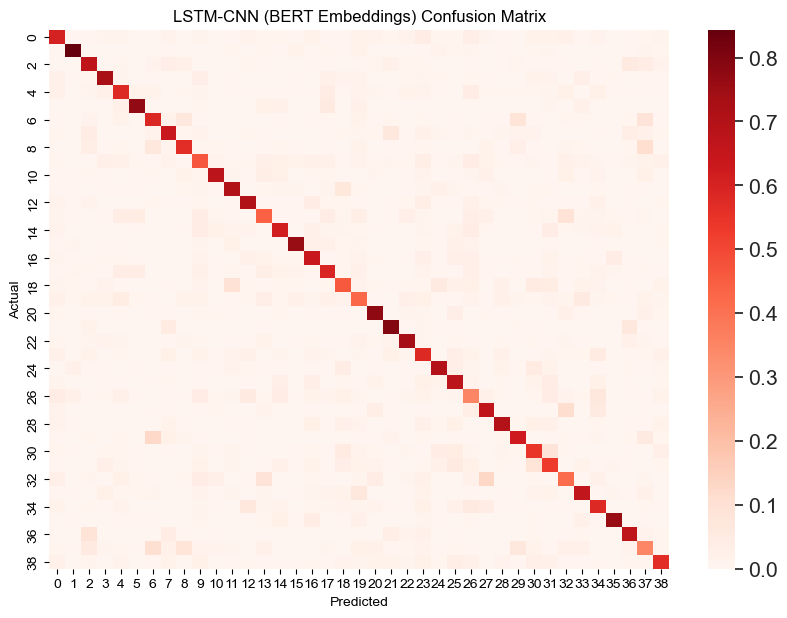

In [83]:
output_metrics(Y_pred, Y_test, normalize_cm=True, title_cm='LSTM-CNN (BERT Embeddings) Confusion Matrix')